<table align="center">
  <td align="center"><a target="_blank" href="https://deeplearning.mit.edu">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="http://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_google_colab.png" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_github.png" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
  <td align="center"><a target="_blank" align="center" href="https://www.youtube.com/watch?v=O5xeyoRL95U&list=PLrAXtmErZgOeiKm4sgNOknGvNjby9efdf">
        <img src="https://deeplearning.mit.edu/files/images/github/icon_youtube.png" style="padding-bottom:5px;" />Watch YouTube Videos</a></td>
<!--   <td><a target="_blank" href="link">
        <img src="image" />text</a></td> -->
</table>

In [213]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU, Embedding, Concatenate
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential

# Commonly used modules
import numpy as np
import os
import sys
import math
from math import ceil, sqrt
from ast import literal_eval

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.2.0


In [189]:
hm_train_stats

,hm_c_AGE,hm_c_AST/TOV,hm_c_AST_PCT,hm_c_AST_PP,hm_c_AST_TOT,hm_c_BLK_PP,hm_c_BLK_TOT,hm_c_DREB_PCT,hm_c_DREB_PP,hm_c_DREB_TOT,hm_c_FG2A_PP,hm_c_FG2A_TOT,hm_c_FG2M_PP,hm_c_FG2M_TOT,hm_c_FG2_PCT,hm_c_FG3A_PP,hm_c_FG3A_TOT,hm_c_FG3M_PP,hm_c_FG3M_TOT,hm_c_FG3_FREQ,hm_c_FG3_PCT,hm_c_FTA_PP,hm_c_FTA_TOT,hm_c_FTM_PP,hm_c_FTM_TOT,hm_c_FT_PCT,hm_c_HEIGHT,hm_c_L,hm_c_MIN_TOT,hm_c_NET_RATING,hm_c_OREB_PCT,hm_c_OREB_PP,hm_c_OREB_TOT,hm_c_PFD_PP,hm_c_PFD_TOT,hm_c_PF_PP,hm_c_PF_TOT,hm_c_PLUS_MINUS,hm_c_STL_PP,hm_c_STL_TOT,...,hm_g_2_DREB_PP,hm_g_2_DREB_TOT,hm_g_2_FG2A_PP,hm_g_2_FG2A_TOT,hm_g_2_FG2M_PP,hm_g_2_FG2M_TOT,hm_g_2_FG2_PCT,hm_g_2_FG3A_PP,hm_g_2_FG3A_TOT,hm_g_2_FG3M_PP,hm_g_2_FG3M_TOT,hm_g_2_FG3_FREQ,hm_g_2_FG3_PCT,hm_g_2_FTA_PP,hm_g_2_FTA_TOT,hm_g_2_FTM_PP,hm_g_2_FTM_TOT,hm_g_2_FT_PCT,hm_g_2_HEIGHT,hm_g_2_L,hm_g_2_MIN_TOT,hm_g_2_NET_RATING,hm_g_2_OREB_PCT,hm_g_2_OREB_PP,hm_g_2_OREB_TOT,hm_g_2_PFD_PP,hm_g_2_PFD_TOT,hm_g_2_PF_PP,hm_g_2_PF_TOT,hm_g_2_PLUS_MINUS,hm_g_2_STL_PP,hm_g_2_STL_TOT,hm_g_2_TOV_PP,hm_g_2_TOV_TOT,hm_g_2_TS_PCT,hm_g_2_USG_PCT,hm_g_2_W,hm_g_2_W_PCT,hm_W_PCT,hm_GP
12664,28.0,0.775862,0.063,0.019,45,0.022,52,0.137,0.064,153,0.164,394,0.080,192,0.487310,0.045,108,0.012,30,0.215139,0.278,0.042,102,0.035,84,0.824,84,27,1257.120000,-6.1,0.053,0.029,69,0.044,107,0.042,100,-123,0.006,14,...,0.037,143,0.107,413,0.046,178,0.430993,0.051,195,0.016,62,0.320724,0.318,0.032,122,0.023,88,0.721,73,34,2017.310000,0.3,0.027,0.014,54,0.033,128,0.041,157,25,0.020,78,0.033,129,0.476,0.181,31,0.477,0.405,37.0
5965,35.0,1.365591,0.107,0.034,127,0.035,132,0.277,0.141,529,0.131,492,0.067,253,0.514228,0.001,4,0.000,1,0.008065,0.250,0.048,182,0.035,132,0.725,83,46,1925.365000,-5.4,0.084,0.043,161,0.037,141,0.034,129,-205,0.014,51,...,0.030,156,0.108,564,0.053,280,0.496454,0.064,337,0.025,131,0.374029,0.389,0.067,350,0.057,299,0.854,75,59,2676.651667,-8.7,0.017,0.009,45,0.059,308,0.033,172,-459,0.015,78,0.031,164,0.593,0.205,19,0.244,0.238,80.0
13739,21.0,0.666667,0.056,0.019,66,0.024,86,0.179,0.092,324,0.112,397,0.062,217,0.546599,0.001,2,0.000,0,0.005013,0.000,0.058,205,0.029,103,0.502,84,33,1770.550000,1.8,0.107,0.056,199,0.053,186,0.063,222,46,0.011,38,...,0.076,364,0.248,1183,0.113,541,0.457312,0.060,288,0.018,86,0.195785,0.299,0.137,654,0.114,546,0.835,75,27,2301.823333,4.7,0.051,0.026,124,0.093,443,0.039,184,247,0.029,140,0.061,293,0.536,0.368,40,0.597,0.487,39.0
6591,34.0,1.542373,0.070,0.023,91,0.022,86,0.214,0.110,434,0.101,401,0.047,189,0.471322,0.081,319,0.029,113,0.443056,0.354,0.026,101,0.020,78,0.772,83,34,2122.505000,1.5,0.028,0.014,56,0.021,84,0.050,197,83,0.016,62,...,0.036,143,0.188,735,0.082,320,0.435374,0.025,99,0.007,28,0.118705,0.283,0.088,347,0.069,271,0.781,72,32,2092.430000,-1.5,0.015,0.008,30,0.081,316,0.022,86,-46,0.022,88,0.037,146,0.504,0.258,25,0.439,0.529,51.0
10810,24.0,0.280000,0.020,0.007,28,0.029,112,0.207,0.100,384,0.128,488,0.082,314,0.643443,0.000,0,0.000,0,0.000000,0.000,0.065,249,0.025,96,0.386,83,26,2009.690000,8.0,0.114,0.055,210,0.053,201,0.050,192,274,0.013,48,...,0.038,30,0.052,42,0.025,20,0.476190,0.113,90,0.041,33,0.681818,0.367,0.060,48,0.056,45,0.938,75,6,418.300000,5.2,0.005,0.003,2,0.046,37,0.031,25,46,0.015,12,0.033,26,0.601,0.194,16,0.727,0.687,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11823,31.0,1.944444,0.122,0.040,140,0.011,39,0.253,0.126,442,0.129,452,0.065,227,0.502212,0.002,7,0.000,0,0.015251,0.000,0.038,135,0.026,92,0.681,82,40,1800.238333,1.7,0.100,0.053,187,0.043,152,0.047,164,63,0.020,69,...,0.045,201,0.116,513,0.051,223,0.434698,0.042,185,0.014,63,0.265043,0.341,0.034,149,0.028,125,0.839,75,48,2252.110000,-5.6,0.009,0.005,22,0.035,156,0.030,133,-240,0.013,56,0.030,133,0.498,0.176,32,0.400,0.3

In [186]:
stats = pd.read_csv('training_data_mixed_model_v2.csv')
bop = pd.read_csv("bag_of_players.csv")
df = pd.merge(stats, bop, on="game_id")
df = df.drop("result_x", axis = 1)
df = df.rename(columns = {"result_y":"result"})

X_train, X_test, y_train, y_test = train_test_split(df.drop("result", axis = 1), df["result"], test_size=0.10)
hm_train_stats = X_train[[x for x in total_dataset.columns if x.startswith("hm_")]].copy()
hm_train_bop = X_train["home_players"].copy()
aw_train_stats = X_train[[x for x in total_dataset.columns if x.startswith("aw_")]].copy()
aw_train_bop = X_train["away_players"].copy()

hm_test_stats = X_test[[x for x in total_dataset.columns if x.startswith("hm_")]].copy()
hm_test_bop = X_test["home_players"].copy()
aw_test_stats = X_test[[x for x in total_dataset.columns if x.startswith("aw_")]].copy()
aw_test_bop = X_test["away_players"].copy()


In [234]:
from sklearn.model_selection import train_test_split

num_train_examples = len(y_train)
num_test_examples = len(y_test)

stats_dimension = hm_train_stats.shape[1]

# get per-feature statistics (mean, standard deviation) from the training set to normalize by -- FOR HOME
hm_train_mean = np.mean(hm_train_stats, axis=0)
hm_train_std = np.std(hm_train_stats, axis=0)
hm_train_stats = (hm_train_stats - hm_train_mean) / hm_train_std

# get per-feature statistics (mean, standard deviation) from the training set to normalize by -- FOR AWAY
aw_train_mean = np.mean(aw_train_stats, axis=0)
aw_train_std = np.std(aw_train_mean, axis=0)
aw_train_stats = (aw_train_stats - aw_train_mean) / aw_train_std

In [235]:
aw_train_stats.shape[1]

232

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Let's build a network with 1 hidden layer of 20 neurons, and use mean squared error (MSE) as the loss function (most common one for regression problems):

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_features` and `train_labels` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [203]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

def lst_removewspc(lst):
  x = []
  for st in lst:
    st = st.replace(" ", "")
    st = st.replace(".", "")
    st = st.replace("-", "")
    x.append(st)
  return x

hm_train_bop = hm_train_bop.apply(lambda x: literal_eval(str(x)))
aw_train_bop = aw_train_bop.apply(lambda x: literal_eval(str(x)))
hm_train_bop = hm_train_bop.apply(lambda x: lst_removewspc(x))
aw_train_bop = aw_train_bop.apply(lambda x: lst_removewspc(x))

playernames_set = set()
for index,value in hm_train_bop.iteritems():
  playernames_set.update(value)
for index,value in aw_train_bop.iteritems():
  playernames_set.update(row.away_players)

VOCAB_SIZE = len(playernames_set)
encoded_home = []
for index,value in hm_train_bop.iteritems():
  concat_string = " ".join(value)
  encoded_home.append(one_hot(concat_string,VOCAB_SIZE))
encoded_away = []
for index,value in aw_train_bop.iteritems():
  concat_string = " ".join(value)
  encoded_away.append(one_hot(concat_string,VOCAB_SIZE))

MAX_LENGTH = 5
padded_hm_encodings = pad_sequences(encoded_home, maxlen=MAX_LENGTH, padding = "post", truncating = "post")
padded_aw_encodings = pad_sequences(encoded_away, maxlen=MAX_LENGTH, padding = "post", truncating = "post")

In [241]:
inp_hm_stats = tf.keras.Input(shape=(hm_train_stats.shape[1],), name = "home_stats")
inp_hm_bop = tf.keras.Input(shape=(padded_hm_encodings.shape[1],), name = "home_bag_of_players")
inp_aw_stats = tf.keras.Input(shape=(aw_train_stats.shape[1],), name = "away_stats")
inp_aw_bop = tf.keras.Input(shape=(padded_aw_encodings.shape[1],), name = "away_bag_of_players")

#home stats
dense_hm_stats = tf.keras.layers.Dense(ceil(1/3*X_train.shape[1]), kernel_regularizer="l1", name = "dense_for_home_stats")(inp_hm_stats)
lky_hm_stats = tf.keras.layers.LeakyReLU(alpha=0.2)(dense_hm_stats)

#home bag of players
embedding_hm = tf.keras.layers.Embedding(VOCAB_SIZE, 8, input_length = MAX_LENGTH)(inp_hm_bop)
flatten_hm = tf.keras.layers.Flatten()(embedding_hm)

#home together
home_merged = tf.keras.layers.concatenate([flatten_hm, lky_hm_stats], axis=1, name = "home_merged")
dropout_hm_merged = tf.keras.layers.Dropout(0.25, name = "dropout_hm_merged")(home_merged)
dense_hm = tf.keras.layers.Dense(ceil(sqrt(1/3*X_train.shape[1])), kernel_regularizer="l2", name = "dense_all_home")(dropout_hm_merged)
lky_hm = tf.keras.layers.LeakyReLU(alpha=0.2)(dense_hm)

#away stats
dense_aw_stats = tf.keras.layers.Dense(ceil(1/3*X_train.shape[1]), kernel_regularizer="l1", name = "dense_for_away_stats")(inp_aw_stats)
lky_aw_stats = tf.keras.layers.LeakyReLU(alpha=0.2)(dense_aw_stats)

#away bag of players
embedding_aw = tf.keras.layers.Embedding(VOCAB_SIZE, 8, input_length = MAX_LENGTH)(inp_aw_bop)
flatten_aw = tf.keras.layers.Flatten()(embedding_aw)

#away together
away_merged = tf.keras.layers.concatenate([flatten_aw, lky_aw_stats], axis=1, name = "away_merged")
dropout_aw_merged = tf.keras.layers.Dropout(0.25, name = "dropout_aw_merged")(away_merged)
dense_aw = tf.keras.layers.Dense(ceil(sqrt(1/3*X_train.shape[1])), kernel_regularizer="l2", name = "dense_all_away")(dropout_aw_merged)
lky_aw = tf.keras.layers.LeakyReLU(alpha=0.2)(dense_aw)

#all together
merged = tf.keras.layers.concatenate([lky_hm, lky_aw], axis=1, name = "all_merged")
output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = "output")(merged)

model = keras.Model(inputs = [inp_hm_stats, inp_hm_bop, inp_aw_stats, inp_aw_bop], outputs = output)

In [242]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_bag_of_players (InputLayer [(None, 5)]          0                                            
__________________________________________________________________________________________________
home_stats (InputLayer)         [(None, 232)]        0                                            
__________________________________________________________________________________________________
away_bag_of_players (InputLayer [(None, 5)]          0                                            
__________________________________________________________________________________________________
away_stats (InputLayer)         [(None, 232)]        0                                            
____________________________________________________________________________________________

In [243]:
model.compile(optimizer="adam", 
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights = True)

history = model.fit([np.array(hm_train_stats), np.array(padded_hm_encodings), np.array(aw_train_stats), np.array(padded_aw_encodings)], y_train, epochs=1000, verbose=1, validation_split = 0.1,
                    callbacks=[early_stop], shuffle = True, batch_size = 32)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

acc = float(hist['val_accuracy'].tail(1))
max_acc = float(max(list(hist['val_accuracy'])))
print()
print('Max accuracy on validation set: {}'.format(round(max_acc, 3)))

Epoch 1/1000
486/486 [==============================] - 2s 4ms/step - loss: 5.0967 - accuracy: 0.6820 - val_loss: 0.7621 - val_accuracy: 0.7039
Epoch 2/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.7438 - accuracy: 0.6994 - val_loss: 0.7272 - val_accuracy: 0.7178
Epoch 3/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.7177 - accuracy: 0.7097 - val_loss: 0.7228 - val_accuracy: 0.7074
Epoch 4/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.7026 - accuracy: 0.7146 - val_loss: 0.7121 - val_accuracy: 0.7103
Epoch 5/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.6926 - accuracy: 0.7183 - val_loss: 0.7155 - val_accuracy: 0.6912
Epoch 6/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.6808 - accuracy: 0.7244 - val_loss: 0.7093 - val_accuracy: 0.7016
Epoch 7/1000
486/486 [==============================] - 2s 4ms/step - loss: 0.6746 - accuracy: 0.7286 - val_loss: 0.7158 - val_accuracy:

In [ ]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


model = keras.Sequential([
        Dense(ceil(2/3*X_train.shape[1]), kernel_regularizer="l1"),
        LeakyReLU(alpha=0.2),
        Dropout(0.1),
        Dense(ceil(sqrt(2/3*X_train.shape[1])), kernel_regularizer="l2"),
        LeakyReLU(alpha=0.5),
        Dense(1, activation = "sigmoid")
    ])

model.compile(optimizer="adam", 
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs=1000, verbose=1, validation_split = 0.1,
                    callbacks=[early_stop], shuffle = True, batch_size = 128)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

acc = float(hist['val_accuracy'].tail(1))
max_acc = float(max(list(hist['val_accuracy'])))
print()
print('Final accuracy on validation set: {}'.format(round(acc, 3)))
print('Max accuracy on validation set: {}'.format(round(max_acc, 3)))

Now, let's plot the loss function measure on the training and validation sets. The validation set is used to prevent overfitting ([learn more about it here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)). However, because our network is small, the training convergence without noticeably overfitting the data as the plot shows.

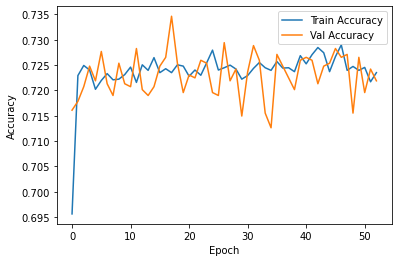

In [73]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    plt.legend()

plot_history()

Next, compare how the model performs on the test dataset:

In [74]:
test_features_norm = (X_test - train_mean) / train_std
loss, accuracy = model.evaluate(test_features_norm, y_test)
print('Accuracy on test set: {}'.format(round(accuracy, 3)))

60/60 [==============================] - 0s 3ms/step - loss: 0.7391 - accuracy: 0.7204
Accuracy on test set: 0.72


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 98.68% on the training data.

### Make predictions

With the model trained, we can use it to make predictions about some games.



## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.